Parse Text Data, make Train Split
---

In [13]:
import glob
import csv
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, vstack
import numpy as np
from sklearn.preprocessing import normalize

freq_file = "word_freq(www.wordfrequency.info).csv"
lit_freq = pd.read_csv(freq_file, header=None)

def parse_lyrics():
    parsed = {"unique_line_ratios": [], "unique_word_ratios_song": [], "artists": [],
             "titles": [], "genres": [], "raw_lyrics": [], "total_word_counts": [], 
              "average_character_count_word":[], "average_words_per_line":[],
              "count_nouns":[], "count_verbs":[], "count_adjectives":[],
              "count_pronouns":[], "count_adverbs": [],
             "word_frequency":[], "rare_words_count":[]}
        
    #iterate through files
    for filename in glob.iglob('data/*.txt'):
        genre = filename[5:len(filename)-4]
        numberOfSongs = 0
        file = open(filename, encoding='utf8')
        lines = file.readlines()
        i = 0
        while i < len(lines) and not lines[i].startswith("###"):
            i = i + 1
        while i < len(lines):
            numberOfSongs = numberOfSongs + 1
            parsed["artists"].append(lines[i][3:].strip())
            parsed["titles"].append(lines[i+1][3:].strip())
            parsed["genres"].append(genre) 
            i = i + 2
            #extract features from song
            
            lyrics = []
            while i < len(lines) and not lines[i].startswith("###"):
                line = lines[i].strip()                
                if line != "":
                    lyrics.append(line)
                i = i + 1
                
            lyric_string = make_lyric_string(lyrics)
            
            parsed["raw_lyrics"].append(lyric_string)
            
            parsed["unique_line_ratios"].append(calc_unique_line_ratio(lyrics))
            parsed["unique_word_ratios_song"].append(calc_unique_word_ratio_song(lyric_string))
            
            parsed["total_word_counts"].append(count_words(lyric_string))
            parsed["average_character_count_word"].append(count_characters(lyric_string)/count_words(lyric_string))
            parsed["average_words_per_line"].append(count_words(lyric_string)/len(lyrics))
            
            parsed["count_nouns"].append(count_nouns(lyrics))
            parsed["count_verbs"].append(count_verbs(lyrics))
            parsed["count_adjectives"].append(count_adjectives(lyrics))
            parsed["count_pronouns"].append(count_pronouns(lyrics))
            parsed["count_adverbs"].append(count_adverbs(lyrics))
            
            parsed["word_frequency"].append(find_word_frequency(lyric_string))
            parsed["rare_words_count"].append(count_rare_words(lyric_string))
            
    return parsed

    
def calc_unique_line_ratio(lyrics):
    return len(set(lyrics)) / len(lyrics)

def make_lyric_string(lyric_lines):
    lyric_string = ''
    for l in lyric_lines:
        lyric_string += l+' '
    return lyric_string 

def count_words(lyric_string):
    return len(lyric_string.split())

def calc_unique_word_ratio_song(lyric_string):
    return len(set(lyric_string.split())) / len(lyric_string.split())

def count_characters(lyrics_string):
    return len(lyrics_string)-lyrics_string.count(' ')

def count_nouns(lyrics_string):
    tokenized = []
    for sent in lyrics_string:
        tokenized.append(word_tokenize(sent))
    tagged = pos_tag_sents(tokenized,tagset='universal')
    concat = [item for sublist in tagged for item in sublist]
    counts = Counter([j for i,j in concat])
    return counts['NOUN']

def count_verbs(lyrics_string):
    tokenized = []
    for sent in lyrics_string:
        tokenized.append(word_tokenize(sent))
    tagged = pos_tag_sents(tokenized,tagset='universal')
    concat = [item for sublist in tagged for item in sublist]
    counts = Counter([j for i,j in concat])
    return counts['VERB']

def count_adjectives(lyrics_string):
    tokenized = []
    for sent in lyrics_string:
        tokenized.append(word_tokenize(sent))
    tagged = pos_tag_sents(tokenized,tagset='universal')
    concat = [item for sublist in tagged for item in sublist]
    counts = Counter([j for i,j in concat])
    return counts['ADJ']

def count_pronouns(lyrics_string):
    tokenized = []
    for sent in lyrics_string:
        tokenized.append(word_tokenize(sent))
    tagged = pos_tag_sents(tokenized,tagset='universal')
    concat = [item for sublist in tagged for item in sublist]
    counts = Counter([j for i,j in concat])
    return counts['PRON']

def count_adverbs(lyrics_string):
    tokenized = []
    for sent in lyrics_string:
        tokenized.append(word_tokenize(sent))
    tagged = pos_tag_sents(tokenized,tagset='universal')
    concat = [item for sublist in tagged for item in sublist]
    counts = Counter([j for i,j in concat])
    return counts['AVD']
def find_word_frequency(lyrics):
    idx = find_idx(lit_freq, lyrics)
    word_freq = []
    for i in idx:
        word_freq.append(lit_freq[3][i])
    return word_freq

def find_idx(lf, lyr):
    lyr = set(lyr.split())
    idx = [] 
    for word in lyr:
        for ind, comp in enumerate(lf[1][1:]):
            if word == comp:
                idx.append(ind+1)
    return idx

def count_rare_words(lyrics):
    lyr = set(lyrics.split())
    count = 0
    for word in lyr:
        if word not in lit_freq[1][1:]:
            count =+ 1
    return count

##Parse The Data
parsed = parse_lyrics()
##Prepare "Dumb" Features
vectorizer = TfidfVectorizer(stop_words="english")
data_bow = vectorizer.fit_transform(parsed["raw_lyrics"]).toarray()

##Make More intelligent Features
data_feature = vectorizer.fit_transform(parsed["raw_lyrics"]).toarray()

data_feature = np.append(data_feature, np.asarray(parsed["unique_line_ratios"]).reshape(-1, 1), 1)
data_feature = np.append(data_feature, normalize(np.asarray(parsed["unique_word_ratios_song"]).reshape(-1, 1)), 1)

data_feature = np.append(data_feature, normalize(np.asarray(parsed["total_word_counts"]).reshape(-1, 1)), 1)
data_feature = np.append(data_feature, normalize(np.asarray(parsed["average_character_count_word"]).reshape(-1, 1)), 1)
data_feature = np.append(data_feature, normalize(np.asarray(parsed["average_words_per_line"]).reshape(-1, 1)), 1)

data_feature = np.append(data_feature, normalize(np.asarray(parsed["count_nouns"]).reshape(-1, 1)), 1)
data_feature = np.append(data_feature, normalize(np.asarray(parsed["count_verbs"]).reshape(-1, 1)), 1)
data_feature = np.append(data_feature, normalize(np.asarray(parsed["count_adjectives"]).reshape(-1, 1)), 1)
data_feature = np.append(data_feature, normalize(np.asarray(parsed["count_pronouns"]).reshape(-1, 1)), 1)
data_feature = np.append(data_feature, normalize(np.asarray(parsed["count_adverbs"]).reshape(-1, 1)), 1)

#data_feature = np.append(data_feature, normalize(np.asarray(parsed["word_frequency"])), 1)
data_feature = np.append(data_feature, normalize(np.asarray(parsed["rare_words_count"]).reshape(-1, 1)), 1)

titles_train, titels_test, raw_lyrics_train, raw_lyrics_test, X_train_feature, X_test_feature, X_train_bow, X_test_bow, y_train, y_test = train_test_split(parsed['titles'], parsed['raw_lyrics'], data_feature, data_bow, parsed['genres'], test_size=0.20, random_state=46)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


Classify
---

In [14]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score

cls = OneVsRestClassifier(SVC(kernel="linear", random_state=0, probability=True))

cls.fit(X_train_feature, y_train)
pred_feature = cls.predict(X_test_feature)
pred_props = cls.predict_proba(X_test_feature)

cls.fit(X_train_bow, y_train)
pred_bow = cls.predict(X_test_bow)

Evaluate
---

### BOW Classifier ###



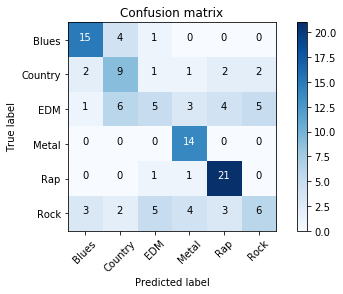

F1 micro: 0.578512396694
F1 macro: 0.559700786358


### Feature Classifier ###



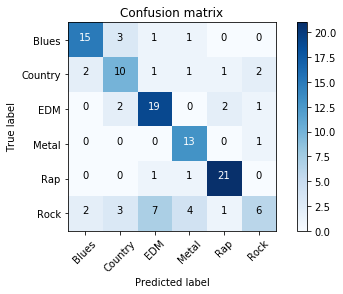

F1 micro: 0.694214876033
F1 macro: 0.676830453121


In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    
print("### BOW Classifier ###\n")    
plot_confusion_matrix(confusion_matrix(y_test, pred_bow), ["Blues","Country", "EDM", "Metal", "Rap", "Rock"])
print ("F1 micro: " + str(f1_score(pred_bow, y_test, average='micro')))
print("F1 macro: " + str(f1_score(pred_bow, y_test, average='macro')))

print("\n\n### Feature Classifier ###\n")    
plot_confusion_matrix(confusion_matrix(y_test, pred_feature), ["Blues","Country", "EDM", "Metal", "Rap", "Rock"])
print ("F1 micro: " + str(f1_score(pred_feature, y_test, average='micro')))
print("F1 macro: " + str(f1_score(pred_feature, y_test, average='macro')))

Examine Mistakes in More Detail
---

In [16]:
for idx, genre in enumerate(y_test):
    if (genre != pred_feature[idx]):
        print ("\n###########################################################\n")
        print ("Song: "+titels_test[idx]+"\n")
        print ("Was "+genre+" Predicted "+pred_feature[idx] + "\n")
        #print ("confidence: ", pred_props[idx])
        print ("\n"+raw_lyrics_test[idx])
        


###########################################################

Song: Sassy

Was Rock Predicted EDM


We're rolling, you guys Why? Why? Why? Why? Why? Why? Why am I here? Why am I there? I don't care CARE! Oh, why I'm old Sit back down Sit back down Sit back down 'CAUSE I SAID SO! [Inger Lorre:] "You're so stupid I would have done anything for you Honey, your reputation is shit in this town You're so stupid I would have done anything for you Honey, your reputation is shit in this town" Oh, why? She's sassy She's walking tall 

###########################################################

Song: See See Baby

Was Blues Predicted Country


See-see baby See what you have done, Lordy mama No need to worry See-see baby See what you have done Yes, you've told me a lie Now you man have come That man you got, don't love you Yes, he told me so, Lordy mama No need to worry The man don't love you, yes he told me so He's just only jivin' you, baby He in love with the girl next do' Oh, an I love yo tea

Look At The Most Informative Words
---

In [17]:
def print_top10(vectorizer, clf, class_labels):
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-20:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))
        
print_top10(vectorizer, cls,  ["Blues","Country", "EDM", "Metal", "Rap", "Rock"])

Blues: cryin rain long mean crossroad man tell nough want christmas goin dog mornin gonna blues yes spoonful mmm woman baby
Country: sweetheart tonight door loved shout softly ruby doodlin little bitty ve used darlin thinks texas miles lonesome heartache love heart
EDM: russia paradise hear push lovers dreaming satisfaction reason hey blessed firestarter feeling animals feel light miracle way la oh yeah
Metal: dark maze reality mentally pain eternity body gods god guts strength dead mind death shall flesh souls life existence blood
Rap: niggaz ghetto shady niggas king ha rap stand snoop im gotta yo like ain bitch money ya fuck nigga shit
Rock: credit 200 know outside desolate protect pull doot finally land broken asking wrong forever requiem primitive known standing fall time
